In [2]:
from copy import deepcopy
import tqdm

import jax.numpy as jnp
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch

from adaptive_mcmc.distributions.distribution import GaussianMixture, FunnelDistribution, Gaussian
from adaptive_mcmc.samplers import (
    base_sampler, mala, fishermala, hmc, hmcadaptive
)
from adaptive_mcmc.samplers.stopping_rule import NoStop
from adaptive_mcmc.tools.benchmark import BenchmarkUtils
from adaptive_mcmc.tools.metrics import compute_ess, compute_emd

2025-05-03 22:58:14.403286: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746302294.412417   27148 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746302294.415143   27148 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
seed = 123
torch.manual_seed(seed)

device = "cpu"

hparams = {
    "mala": mala.MALAParams(
        sigma=1.0,
        sigma_lr=0.015,
        target_acceptance=0.574,
        device=device,
    ),
    "fisher_mala": fishermala.FisherMALAParams(dampening=10.),
    "hmc_vanilla": hmc.HMCParams(lf_step_count=5, lf_step_size=0.1, no_grad=True),
    "hmcadaptive_hutch": hmcadaptive.HMCAdaptiveParams(
        lf_step_count=5,
        lf_step_size=0.1,
        learning_rate=1e-4,
        truncation_level_prob=0.5,
        min_truncation_level=2,
        entropy_weight=1e1,
        entropy_weight_max=1e2,
        penalty_weight_max=1e1,
        penalty_weight=1e-3,
        penalty_weight_adaptive_rate=1e-3,
        clip_grad_value=1e5,
        prec_init_scale=1e-1,
        lanczos_steps=2,
        krylov_probe_vectors=2,
        # iter_count=10000,
        # scheduler_cls=hmcadaptive.WarmupCosineAnnealingScheduler
    ),
    "hmcadaptive_hutch_lanczos": hmcadaptive.HMCAdaptiveParams(
        lf_step_count=2,
        lf_step_size=0.1,
        learning_rate=1e-4,
        entropy_weight=1e-1,
        entropy_weight_min=1e-8,
        entropy_weight_max=1e2,
        clip_grad_value=1e5,
        prec_init_scale=1e-1,
        trace_method=hmcadaptive.TraceMethod.HUTCH_LANCZOS,
        lanczos_steps=4,
        krylov_probe_vectors=3,
        # iter_count=10000,
        # scheduler_cls=hmcadaptive.WarmupCosineAnnealingScheduler
    ),
}

In [4]:
chain_count = 50
dimensions = [4, 8, 16, 32, 64] #8, 16, 32, 64] #, 32] #[8, 16, 32, 64] #, 128] #, 256]
gaussian_count = 5
tv_threshold = 0.05
sample_count = 1000
sample_iter_limit = 5000
burn_in_iter_count = 2500
probe_period = 25000
tail_count_cap = 1000

# stopping_rule = TVStop(threshold=tv_threshold, density_probe_count=1000,
#                        projection_count=25, tail_count_cap=tail_count_cap)

stopping_rule = NoStop(density_probe_count=500,
                       projection_count=25,
                       tail_count_cap=tail_count_cap
                      )

algs = {
    # "mala": mala.MALAVanilla(
    #     pipeline=None,
    #     name="MALA",
    #     sigma_burn_in_params=hparams["mala"].copy(),
    #     sigma_burn_in_iter_count=burn_in_iter_count,
    #     sample_iter_count=sample_iter_limit,
    #     stopping_rule=stopping_rule,
    #     probe_period=probe_period,
    # ),
    # "fisher_mala": fishermala.FisherMALAVanilla(
    #     pipeline=None,
    #     name="FisherMALA",
    #     sigma_burn_in_params=hparams["fisher_mala"].copy(),
    #     sigma_burn_in_iter_count=500,
    #     prec_burn_in_params=hparams["fisher_mala"].copy(),
    #     prec_burn_in_iter_count=burn_in_iter_count - 500,
    #     sample_iter_count=sample_iter_limit,
    #     stopping_rule=stopping_rule,
    #     probe_period=probe_period,
    # ),
    "hmc_vanilla": hmc.HMCVanilla(
        pipeline=None,
        name="HMCVanilla",
        params=hparams["hmc_vanilla"].copy(),
        sample_iter_count=sample_iter_limit,
        burn_in_iter_count=burn_in_iter_count,
        stopping_rule=stopping_rule,
        probe_period=probe_period,
    ),
    "hmcadaptive_hutch": hmcadaptive.HMCAdaptive(
        pipeline=None,
        name="HMCAdaptiveHutch",
        params=hparams["hmcadaptive_hutch"].copy(),
        sample_iter_count=sample_iter_limit,
        burn_in_iter_count=burn_in_iter_count,
        stopping_rule=stopping_rule,
        probe_period=probe_period,
    ),
    "hmcadaptive_hutch_lanczos": hmcadaptive.HMCAdaptive(
        pipeline=None,
        name="HMCAdaptiveHutchLanczos",
        params=hparams["hmcadaptive_hutch_lanczos"].copy(),
        sample_iter_count=sample_iter_limit,
        burn_in_iter_count=burn_in_iter_count,
        stopping_rule=stopping_rule,
        probe_period=probe_period,
    ),
}

In [5]:
def get_random_GM(gaussian_count: int, dimension: int, cube: float, eps: float=5e-1, scale: float=1.):
    true_means = torch.rand((gaussian_count, dimension)) * cube - cube / 2
    scales = torch.rand((gaussian_count, dimension)) * scale

    while True:
        try:
            true_covs = torch.rand((gaussian_count, dimension, dimension))
            true_covs, _ = torch.linalg.qr(true_covs)
        
            true_covs = (
                true_covs @ torch.diag_embed(scales) @ true_covs.permute(0, 2, 1) 
                + eps * torch.eye(dimension).unsqueeze(0)
            )
            
            # true_covs = (
            #     true_covs @ true_covs.permute(0, 2, 1) +
            #     torch.eye(dimension).repeat(gaussian_count, 1, 1)
            # )
        
            gm = GaussianMixture(
                true_means,
                true_covs,
                torch.full((gaussian_count,), 1/gaussian_count, dtype=torch.float64)
            )
            break
        except ValueError:
            pass
            
    return gm, true_means

In [6]:
def generate_simplex(d: int) -> torch.Tensor:
    I = torch.eye(d)
    
    ones = torch.ones((d, d)) / (d+1)
    v1d = I - ones
    vdp1 = -torch.ones((1, d)) / (d+1)
    return torch.cat([v1d, vdp1], dim=0)


def get_toeplitz_GM(dimension: int, cube: float, rho: float=0.99, sigma: float=1.):
    true_means = generate_simplex(dimension) * cube

    inds = torch.arange(dimension)
    power = torch.abs(inds.unsqueeze(0) - inds.unsqueeze(1))

    true_covs = sigma ** 2 * rho ** power
    true_covs = true_covs.repeat(dimension + 1, 1, 1)

    gm = GaussianMixture(
        true_means,
        true_covs,
        torch.ones(dimension + 1) / (dimension + 1)
    )

    return gm, true_means


def get_toeplitz_gaussian(dimension: int,
                          mean: float = None,
                          rho: float = 0.99,
                          sigma: float = 1.0) -> tuple:
    if mean is None:
        mean = torch.zeros(dimension)
        
    inds = torch.arange(dimension)
    power = torch.abs(inds.unsqueeze(0) - inds.unsqueeze(1))
    cov = (sigma ** 2) * (rho ** power)
    
    return Gaussian(mean=mean, cov=cov), mean.unsqueeze(0)


def sample_se_covariance_torch(dimension, scale=4., noise=0.01, seed=None, device='cpu'):
    if seed is not None:
        torch.manual_seed(seed)

    x = torch.linspace(0, scale, dimension)

    x1 = x.unsqueeze(1)
    x2 = x.unsqueeze(0)
    dist_squared = (x1 - x2) ** 2

    K = torch.exp(-0.5 * dist_squared / (0.1 * scale**2))

    K += noise * torch.eye(dimension, device=device)

    return x, K
    
def get_deterministic_gaussian_se(dimension: int,
                                  mean: float = None,) -> tuple:
    if mean is None:
        mean = torch.zeros(dimension)
        
    _, cov = sample_se_covariance_torch(dimension)
    
    return Gaussian(mean=mean, cov=cov), mean.unsqueeze(0)

In [7]:
dist = FunnelDistribution(8, scale=1.5)

# dist, _ = get_deterministic_gaussian(2, rho=0.8)
# dist, _ = get_deterministic_gaussian_se(32)

# dist, _ = get_random_GM(gaussian_count, dimension, cube=3.)
# dist, _ = get_deterministic_GM(dimension=8, cube=2., rho=0.8)


samples = dist.sample(1000).detach().numpy()

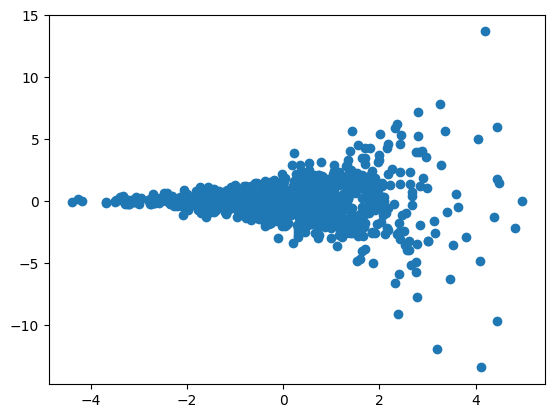

In [8]:
plt.scatter(samples[:, 0], samples[:, 1])

In [9]:
def dist_factory(name, dimension, cube=1., scale=1.5, gaussian_count=5, rho=0.8):
    
    if name == "random_gm":
        return get_random_GM(gaussian_count=gaussian_count, dimension=dimension, cube=cube)
    elif name == "toeplitz_gm":
        return get_toeplitz_GM(dimension, cube=cube, rho=rho)
    elif name == "toeplitz_gaussian":
        return get_toeplitz_gaussian(dimension, rho=rho)
    elif name == "deterministic_gaussian_se":
        return get_deterministic_gaussian_se(dimension)
    elif name == "funnel":
        return FunnelDistribution(dimension, scale=scale), torch.zeros(1, dimension)

In [10]:
def drop_static_chains(samples: torch.Tensor, eps: float = 0.0):
    var_per_chain = samples.var(dim=0, unbiased=False)

    static = (var_per_chain <= eps).all(dim=-1)
    keep_mask = ~static

    return samples[:, keep_mask, :], keep_mask.sum().item()

def compute_results(hist_data, algs, dist_name=None):
    dim_stat = {}

    for dimension in tqdm.notebook.tqdm(dimensions, desc="dimension"):
        rows = []
        for alg in tqdm.notebook.tqdm(algs, desc="alg", leave=False):
            obj = hist_data[dimension][alg]
            cache = obj["cache"]
            pure_runtime = obj["pure_runtime"]
    
            clean_samples, n_kept = drop_static_chains(cache.samples)
    
            metrics = BenchmarkUtils.compute_metrics(clean_samples,
                                                     cache.true_samples)
            metrics["runtime"]      = pure_runtime
            metrics["chains_kept"]  = n_kept
            rows.append(metrics)
    
        df = pd.DataFrame(rows, index=list(algs.keys())).T
        dim_stat[dimension] = df
        print(f"\ndim={dimension}, dist={dist_name}\n", df)
    
        return dim_stat

In [11]:
def run_experiment(dist_name, log=[]):
    hist_data = {}
    runtime = {
        dimension: dict()
        for dimension in dimensions
    }
    pure_runtime = deepcopy(runtime)
    cube = 1
    distance_to_mass_points = cube
    scale = 1.5
    
    for dimension in tqdm.notebook.tqdm(dimensions):
        print("Processing dimension", dimension)
        hist_data[dimension] = {}
        target_dist, true_means = dist_factory(dist_name, dimension)
        
        # target_dist, true_means = get_random_GM(gaussian_count, dimension, cube)
        # gm, true_means = get_deterministic_GM(dimension, cube)
        # true_samples = gm.sample(sample_count)
    
        # target_dist = FunnelDistribution(dimension, scale=scale)
        
        # target_dist, _ = get_deterministic_gaussian(dimension, rho=0.8)
        # target_dist, _ = get_deterministic_gaussian_se(dimension)
    
        # true_means = torch.zeros(1, dimension)
        true_samples = target_dist.sample(sample_count)
        
        starting_points = BenchmarkUtils.generate_starting_points(
            chain_count, dimension,
            true_means,
            distance_to_mass_points,
        )
    
        params = base_sampler.Params(
            target_dist=target_dist,
            starting_point=starting_points.clone(),
            proposal_dist=torch.distributions.MultivariateNormal(
                torch.zeros(dimension, device=device),
                torch.eye(dimension, device=device),
            ),
        )
    
        for alg in algs:
            print("-" * 80)
            base_meta_adj = hparams[alg].copy_update(params)
            if hasattr(base_meta_adj, "sigma"):
                base_meta_adj.sigma /= dimension
    
            algs[alg].load_params(base_meta_adj)
            algs[alg].load_true_samples(true_samples)
            algs[alg].run()
    
            hist_data[dimension][alg] = {
                "cache": algs[alg].pipeline.sample_blocks[-1].iteration.cache,
                "stop_data_hist": algs[alg].pipeline.sample_blocks[-1].stop_data_hist,
                "runtime": algs[alg].pipeline.runtime,
                "pure_runtime": algs[alg].pipeline.pure_runtime,
            }
        print()

    dim_stat = compute_results(hist_data, algs, dist_name)
    log.append({
        "hist_data": hist_data,
        "algs": algs,
        "dist_name": dist_name,
        "dim_stat": dim_stat,
    })

In [12]:
def print_log(log):
    for entry in log:
        for dimension in dimensions:
            print(f"\ndim={dimension}, dist={entry['dist_name']}\n", entry["dim_stat"][dimension])

In [ ]:
dist_names = ["toeplitz_gaussian", "toeplitz_gm", "funnel"]
log = []

for dist_name in dist_names:
    run_experiment(dist_name, log=log)

step_size=0.2040
step_size=0.1793
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.1700
step_size=0.1519
step_size=0.1385
step_size=0.1268
step_size=0.1155
Runtime: 161.79s



dimension:   0%|          | 0/5 [00:00<?, ?it/s]

alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=4, dist=toeplitz_gaussian
                 hmc_vanilla hmcadaptive_hutch hmcadaptive_hutch_lanczos
ess                0.653018          0.679168                  0.048975
tv_mean          0.03388023        0.03581939               0.042489342
tv_conf_sigma  0.0012215422      0.0017307585              0.0019831583
runtime           13.411194         62.462678                101.943945
chains_kept              50                50                        50


  0%|          | 0/5 [00:00<?, ?it/s]

Processing dimension 4
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 2
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.1003
step_size=0.6230
step_size=0.6152
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.6210
step_size=0.6163
step_size=0.6196
step_size=0.6195
step_size=0.6165
Runtime: 16.17s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutch
number of blocks: 2
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.1003
step_size=0.5763
step_size=0.5762
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.5825
step_size=0.5832
step_size=0.5884
step_size=0.5858
step_size=0.5908
Runtime: 79.37s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczos
number of blocks: 2
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.1003
step_size=0.5471
step_size=0.5146
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.4982
step_size=0.4670
step_size=0.4352
step_size=0.4099
step_size=0.3878
Runtime: 152.46s

Processing dimension 8
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 2
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.1003
step_size=0.5177
step_size=0.5230
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.5209
step_size=0.5191
step_size=0.5207
step_size=0.5235
step_size=0.5201
Runtime: 18.03s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutch
number of blocks: 2
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.1003
step_size=0.4641
step_size=0.4649
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.4618
step_size=0.4603
step_size=0.4606
step_size=0.4590
step_size=0.4554
Runtime: 89.22s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczos
number of blocks: 2
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.1003
step_size=0.4474
step_size=0.4134
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.4001
step_size=0.3734
step_size=0.3471
step_size=0.3176
step_size=0.2898
Runtime: 170.70s

Processing dimension 16
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 2
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.1003
step_size=0.4445
step_size=0.4476
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.4489
step_size=0.4480
step_size=0.4479
step_size=0.4485
step_size=0.4466
Runtime: 22.03s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutch
number of blocks: 2
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.1003
step_size=0.3927
step_size=0.3880
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.3825
step_size=0.3771
step_size=0.3754
step_size=0.3715
step_size=0.3667
Runtime: 106.75s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczos
number of blocks: 2
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.1003
step_size=0.3752
step_size=0.3321
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.3168
step_size=0.2867
step_size=0.2578
step_size=0.2329
step_size=0.2113
Runtime: 214.52s

Processing dimension 32
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 2
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.1002
step_size=0.3706
step_size=0.3751
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.3773
step_size=0.3798
step_size=0.3772
step_size=0.3788
step_size=0.3729
Runtime: 33.17s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutch
number of blocks: 2
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.1002
step_size=0.3215
step_size=0.3163
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.3123
step_size=0.3054
step_size=0.2991
step_size=0.2935
step_size=0.2926


In [34]:
print_log(log)


dim=32, dist=toeplitz_gaussian
                hmc_vanilla hmcadaptive_hutch hmcadaptive_hutch_lanczos
ess                    NaN               NaN                       NaN
tv_mean          0.4034469        0.40662557                 0.5795989
tv_conf_sigma  0.021835051        0.02245872               0.018901205
runtime           0.070733          0.216927                  0.330922
chains_kept             50                50                        50

dim=32, dist=toeplitz_gm
                hmc_vanilla hmcadaptive_hutch hmcadaptive_hutch_lanczos
ess                    NaN               NaN                       NaN
tv_mean         0.40342045        0.39977232                0.58536416
tv_conf_sigma  0.022168465       0.021903226               0.018453278
runtime           0.078262          0.445722                   0.86133
chains_kept             50                50                        50

dim=32, dist=funnel
                hmc_vanilla hmcadaptive_hutch hmcadaptive_hutch_lan

In [ ]:
def moving_average(x, window_size=10):
    return np.convolve(x, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10, 6))
window = 100  # adjust as needed

for dimension in dimensions:
    for alg in algs:
        raw = hist_data[dimension][alg][0].accept_prob_hist
        smoothed = moving_average(np.array(raw), window_size=window)
        label = f"{alg} (dim={dimension})"
        plt.plot(smoothed, label=label, alpha=0.8)

plt.xlabel("Iteration")
plt.ylabel("Smoothed Acceptance Probability")
plt.title(f"Moving Average (window={window}) of Acceptance Probabilities")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [30]:
dim_stat = {}
for dimension in tqdm.notebook.tqdm(dimensions):
    df = []
    for alg in tqdm.notebook.tqdm(algs):
        df.append(
            BenchmarkUtils.compute_metrics(
                hist_data[dimension][alg][0].samples,
                hist_data[dimension][alg][0].true_samples,
            )
        )
        df[-1]["runtime"] = pure_runtime[dimension][alg]
    df = pd.DataFrame(df)
    df = df.T
    df.columns = list(algs.keys())

    dim_stat[dimension] = df
    print(f"dim={dimension}", df)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

dim=32               hmcadaptive_hutch_lanczos
ess                            0.022901
tv_mean                     0.102505475
tv_conf_sigma               0.009030327
runtime                      207.830183


In [ ]:
algs["hmc_vanilla"].pipeline.sample_blocks[-1]

In [ ]:
BenchmarkUtils.create_plot(
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.samples[:, [0], :],
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.create_plot(
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.samples[:, [0], :],
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.create_plot(
    hist_data[dimensions[-1]]["hmc_vanilla"]["cache"].samples[:, [0], :],
    hist_data[dimensions[-1]]["hmc_vanilla"]["cache"].true_samples,
)

In [ ]:
BenchmarkUtils.create_plot(
    hist_data[dimensions[-1]]["hmcadaptive_hutch"]["cache"].samples[:, [0], :],
    hist_data[dimensions[-1]]["hmcadaptive_hutch"]["cache"].true_samples,
)

In [ ]:
BenchmarkUtils.create_plot(
    hist_data[dimensions[-1]]["hmcadaptive_hutch_lanczos"]["cache"].samples[:, [0], :],
    hist_data[dimensions[-1]]["hmcadaptive_hutch_lanczos"]["cache"].true_samples,
)

In [ ]:
BenchmarkUtils.create_plot(
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.samples[:, [2], :],
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.create_plot(
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.samples[:, [2], :],
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.create_plot(
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[0].iteration.cache.samples[:, [10], :],
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.create_plot(
    algs["hmcadaptive_hutch_lanczos"].pipeline.sample_blocks[0].iteration.cache.samples[:, [0], :],
    algs["hmcadaptive_hutch_lanczos"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
tv_threshold = 0.05

In [ ]:
pure_runtime

In [ ]:
runtime

In [ ]:
fig, axes = plt.subplots(
    nrows=len(dimensions),
    ncols=2,
    figsize=(13, 4 * len(dimensions),)
)
fig.suptitle(
    f"at most {tail_count_cap} last samples, burn-in={burn_in_iter_count}, "
    f"chain_count={chain_count}, "
    f"TV threshold={tv_threshold}\n" +
    f"mixture of {gaussian_count} gaussians with "
    "random means and covariance matrices"
)

for dim_ind in range(len(dimensions)):
    for alg_ind, alg in enumerate(algs.keys()):

        ticks_count = len(hist_data[dimensions[dim_ind]][alg][1])
        xticks = probe_period * jnp.arange(1, ticks_count + 1)

        axes[dim_ind, alg_ind].plot(
            xticks,
            [
                entry["tv_mean"]
                for entry in hist_data[dimensions[dim_ind]][alg][1]
            ],
            label="TV mean"
        )
        axes[dim_ind, alg_ind].fill_between(
            xticks,
            [
                entry["tv_mean"] - 2 * entry["tv_std"]
                for entry in hist_data[dimensions[dim_ind]][alg][1]
            ],
            [
                entry["tv_mean"] + 2 * entry["tv_std"]
                for entry in hist_data[dimensions[dim_ind]][alg][1]
            ],
            alpha=0.1,
            label="95% CI"
        )
        axes[dim_ind, alg_ind].axhline(tv_threshold, color="r", linestyle="dashed")
        axes[dim_ind, alg_ind].set_title(f"{alg}, dim={dimensions[dim_ind]}")
        if dim_ind + 1 == len(dimensions):
            axes[dim_ind, alg_ind].set_xlabel("iteration")
        axes[dim_ind, alg_ind].set_ylabel("TV")
        axes[dim_ind, alg_ind].legend()

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.params.sigma_prec

In [ ]:
algs["hmcadaptive_hutch_lanczos"].pipeline.sample_blocks[-1].iteration.params.entropy_weight.squeeze()

In [ ]:
algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.params.entropy_weight.squeeze()

In [ ]:
algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.params.penalty_weight.squeeze()

In [ ]:
prec = algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.params.prec[1].detach().numpy()
minv = prec @ prec.T

In [ ]:
prec = algs["hmcadaptive_hutch"].pipeline.sample_blocks[0].iteration.cache.prec[1].detach().numpy()
minv = prec @ prec.T

In [ ]:
algs["hmcadaptive_hutch_lanczos"].pipeline.sample_blocks[1].iteration.params.lf_step_size

In [ ]:
algs["hmcadaptive_hutch"].pipeline.sample_blocks[0].iteration.params.lf_step_size

In [ ]:
minv

In [ ]:
plt.imshow(minv)

In [ ]:
prec = algs["hmcadaptive_hutch_lanczos"].pipeline.sample_blocks[0].iteration.cache.prec[1].detach().numpy()
minv = prec @ prec.T
plt.imshow(minv)

In [ ]:
minv

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.true_samples,
)

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.true_samples,
)

### Reference

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)